## Create Athena Database schema

In [202]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [203]:
ingest_create_athena_db_passed = False

In [204]:
# Restore project S3 paths created during ingestion

%store -r s3_bucket
%store -r project_prefix
%store -r s3_raw_cats_prefix
%store -r s3_raw_noncats_prefix
%store -r s3_processed_combined_prefix
%store -r ingestion_completed

if not ingestion_completed:
    raise RuntimeError("Ingestion not completed. Run the ingestion notebook first.")

print("Cats:", s3_raw_cats_prefix)
print("Noncats:", s3_raw_noncats_prefix)
print("Processed:", s3_processed_combined_prefix)


Cats: s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/
Noncats: s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/noncats/images/
Processed: s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/processed/combined/


## Import PyAthena

In [205]:
from pyathena import connect

In [206]:

database_name = "cat_image_analysis"
table_name = "image_combined"
table_name_landmarks = "landmarks"

bucket = "sagemaker-us-east-1-549206572067"
region = "us-east-1"

s3_combined_location = (
    f"s3://{bucket}/cat-landmarks-project/processed/combined/"
)
s3_landmarks_location = (
    f"s3://{bucket}/cat-landmarks-project/processed/combined/annotations/"
)
s3_staging_dir = f"s3://{bucket}/athena/staging/"


In [207]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [208]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [209]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)

CREATE DATABASE IF NOT EXISTS cat_image_analysis


In [210]:
import pandas as pd

pd.read_sql(statement, conn)

/tmp/ipykernel_692/3803073958.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [211]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_692/3999478089.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,cat_image_analysis
1,default
2,sagemaker_featurestore


In [212]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [213]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [137]:
%store

Stored variables and their in-db values:
ingest_create_athena_db_passed                         -> True
ingest_create_athena_image_combined_passed             -> True
ingestion_completed                                    -> True
project_prefix                                         -> 'cat-landmarks-project'
s3_bucket                                              -> 'sagemaker-us-east-1-549206572067'
s3_processed_combined_prefix                           -> 's3://sagemaker-us-east-1-549206572067/cat-landmar
s3_raw_cats_prefix                                     -> 's3://sagemaker-us-east-1-549206572067/cat-landmar
s3_raw_noncats_prefix                                  -> 's3://sagemaker-us-east-1-549206572067/cat-landmar
setup_dependencies_passed                              -> True
setup_s3_bucket_passed                                 -> True


In [214]:
create_db_sql = f"""
CREATE DATABASE IF NOT EXISTS {database_name}
"""

cursor = conn.cursor()
cursor.execute(create_db_sql)

print(f"Database '{database_name}' is ready")


Database 'cat_image_analysis' is ready


In [215]:
# Drop the Athena table definition (data in S3 is untouched)

drop_sql = f"""
DROP TABLE IF EXISTS {database_name}.{table_name_landmarks}
"""

cursor = conn.cursor()
cursor.execute(drop_sql)

print(f"Dropped table {database_name}.{table_name_landmarks}")


Dropped table cat_image_analysis.landmarks


In [100]:
# Confirm columns and types match what Athena expects
df_check = pd.read_parquet("data/processed/cats/landmarks.parquet")
print(df_check.columns.tolist())
print(df_check.dtypes)
df_check.head(3)


['s3_uri', 'left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'mouth_x', 'mouth_y', 'left_ear_1_x', 'left_ear_1_y', 'left_ear_2_x', 'left_ear_2_y', 'left_ear_3_x', 'left_ear_3_y', 'right_ear_1_x', 'right_ear_1_y', 'right_ear_2_x', 'right_ear_2_y', 'right_ear_3_x', 'right_ear_3_y']
s3_uri            object
left_eye_x       float64
left_eye_y       float64
right_eye_x      float64
right_eye_y      float64
mouth_x          float64
mouth_y          float64
left_ear_1_x     float64
left_ear_1_y     float64
left_ear_2_x     float64
left_ear_2_y     float64
left_ear_3_x     float64
left_ear_3_y     float64
right_ear_1_x    float64
right_ear_1_y    float64
right_ear_2_x    float64
right_ear_2_y    float64
right_ear_3_x    float64
right_ear_3_y    float64
dtype: object


,s3_uri,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,mouth_y,left_ear_1_x,left_ear_1_y,left_ear_2_x,left_ear_2_y,left_ear_3_x,left_ear_3_y,right_ear_1_x,right_ear_1_y,right_ear_2_x,right_ear_2_y,right_ear_3_x,right_ear_3_y
0,data/raw/CAT_00/00000001_000.jpg,175.0,160.0,239.0,162.0,199.0,199.0,149.0,121.0,137.0,78.0,166.0,93.0,281.0,101.0,312.0,96.0,296.0,133.0
1,data/raw/CAT_00/00000001_005.jpg,96.0,96.0,153.0,127.0,103.0,146.0,48.0,20.0,78.0,-37.0,127.0,5.0,210.0,52.0,260.0,63.0,229.0,121.0
2,data/raw/CAT_00/00000001_008.jpg,318.0,222.0,340.0,224.0,327.0,238.0,301.0,199.0,304.0,182.0,321.0,196.0,341.0,197.0,359.0,183.0,361.0,203.0


In [216]:
# SQL statement to execute (Parquet-based Athena table)
statement_landmarks = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_landmarks} (
    s3_uri STRING,
    left_eye_x DOUBLE,  left_eye_y DOUBLE,
    right_eye_x DOUBLE, right_eye_y DOUBLE,
    mouth_x DOUBLE,     mouth_y DOUBLE,

    left_ear_1_x DOUBLE, left_ear_1_y DOUBLE,
    left_ear_2_x DOUBLE, left_ear_2_y DOUBLE,
    left_ear_3_x DOUBLE, left_ear_3_y DOUBLE,

    right_ear_1_x DOUBLE, right_ear_1_y DOUBLE,
    right_ear_2_x DOUBLE, right_ear_2_y DOUBLE,
    right_ear_3_x DOUBLE, right_ear_3_y DOUBLE
)
STORED AS PARQUET
LOCATION '{s3_landmarks_location}'
"""


In [217]:
cursor = conn.cursor()
cursor.execute(statement_landmarks)

print(f"Created (or already exists): {database_name}.{table_name_landmarks}")

Created (or already exists): cat_image_analysis.landmarks


In [189]:
# Recreate image_combined so it reads ONLY metadata parquet files

s3_metadata_location = f"s3://{bucket}/cat-landmarks-project/processed/combined/metadata/"

cursor = conn.cursor()
cursor.execute(f"DROP TABLE IF EXISTS {database_name}.{table_name}")

create_sql = f"""
CREATE EXTERNAL TABLE {database_name}.{table_name} (
    s3_uri      STRING,
    label       BIGINT,
    ingest_time STRING,
    file_size   BIGINT,
    width       INT,
    height      INT
)
STORED AS PARQUET
LOCATION '{s3_metadata_location}'
"""
cursor.execute(create_sql)

print("image_combined now points to:", s3_metadata_location)


image_combined now points to: s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/processed/combined/metadata/


In [190]:
pd.read_sql(f"SELECT * FROM {database_name}.{table_name} LIMIT 5", conn)


/tmp/ipykernel_692/2148037681.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(f"SELECT * FROM {database_name}.{table_name} LIMIT 5", conn)


,s3_uri,label,ingest_time,file_size,width,height
0,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,375,500
1,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,500,375
2,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,500,375
3,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,310372,500,375
4,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,310372,500,333


In [187]:
cursor = conn.cursor()
cursor.execute(statement)

print(f"Created (or already exists): {database_name}.{table_name}")

Created (or already exists): cat_image_analysis.image_combined


In [168]:
statement = "SHOW TABLES in {}".format(database_name)


df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_692/919815141.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,tab_name
0,image_combined
1,image_features
2,landmarks


In [86]:
# Check if the table exists in the SHOW TABLES output
if (df_show["tab_name"] == "image_combined").any():
    ingest_create_athena_image_combined_passed = True
else:
    ingest_create_athena_image_combined_passed = False

print("ingest_create_athena_image_combined_passed =", ingest_create_athena_image_combined_passed)


ingest_create_athena_image_combined_passed = True


In [87]:
%store ingest_create_athena_image_combined_passed

Stored 'ingest_create_athena_image_combined_passed' (bool)


## Checking contents of the image_combined and landmarks

In [191]:
statement = f"""
SELECT *
FROM {database_name}.{table_name}
"""
print(statement)

df = pd.read_sql(statement, conn)
df.head(5)



SELECT *
FROM cat_image_analysis.image_combined



/tmp/ipykernel_692/224683668.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,s3_uri,label,ingest_time,file_size,width,height
0,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,375,500
1,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,500,375
2,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,500,375
3,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,310372,500,375
4,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,310372,500,333


In [225]:
# True if every value in s3_uri is unique (excluding NaN)
is_unique = df['s3_uri'].is_unique

print(is_unique)


True


In [226]:
print("Null count:", df["s3_uri"].isna().sum())


Null count: 0


### S3_URI is a unique field and hence can be used key

In [170]:
statement = f"""
SELECT *
FROM {database_name}.{table_name}
"""
print(statement)

df = pd.read_sql(statement, conn)
df.head(5)



SELECT *
FROM cat_image_analysis.image_combined



/tmp/ipykernel_692/224683668.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,image_id,label,s3_uri,file_size,width,height
0,None,1.0,s3://sagemaker-us-east-1-549206572067/cat-land...,469801.0,375.0,500.0
1,None,1.0,s3://sagemaker-us-east-1-549206572067/cat-land...,469801.0,500.0,375.0
2,None,1.0,s3://sagemaker-us-east-1-549206572067/cat-land...,469801.0,500.0,375.0
3,None,1.0,s3://sagemaker-us-east-1-549206572067/cat-land...,310372.0,500.0,375.0
4,None,1.0,s3://sagemaker-us-east-1-549206572067/cat-land...,310372.0,500.0,333.0


In [227]:
# Join image metadata with landmarks into one DataFrame
# Keep it explicit and readable

statement = f"""
SELECT
    c.s3_uri,
    c.label,
    
    c.file_size,
    c.width,
    c.height,

    l.left_eye_x,
    l.left_eye_y,
    l.right_eye_x,
    l.right_eye_y,
    l.mouth_x,
    l.mouth_y,

    l.left_ear_1_x,
    l.left_ear_1_y,
    l.left_ear_2_x,
    l.left_ear_2_y,
    l.left_ear_3_x,
    l.left_ear_3_y,

    l.right_ear_1_x,
    l.right_ear_1_y,
    l.right_ear_2_x,
    l.right_ear_2_y,
    l.right_ear_3_x,
    l.right_ear_3_y
FROM {database_name}.{table_name} c
LEFT JOIN {database_name}.{table_name_landmarks} l
    ON c.s3_uri = l.s3_uri
"""

df = pd.read_sql(statement, conn)
df.head(10)


/tmp/ipykernel_692/309417654.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,s3_uri,label,file_size,width,height,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,...,left_ear_2_x,left_ear_2_y,left_ear_3_x,left_ear_3_y,right_ear_1_x,right_ear_1_y,right_ear_2_x,right_ear_2_y,right_ear_3_x,right_ear_3_y
0,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_000.jpg,1,469801,375,500,175.0,160.0,239.0,162.0,199.0,...,137.0,78.0,166.0,93.0,281.0,101.0,312.0,96.0,296.0,133.0
1,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_005.jpg,1,469801,500,375,96.0,96.0,153.0,127.0,103.0,...,78.0,-37.0,127.0,5.0,210.0,52.0,260.0,63.0,229.0,121.0
2,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_008.jpg,1,469801,500,375,318.0,222.0,340.0,224.0,327.0,...,304.0,182.0,321.0,196.0,341.0,197.0,359.0,183.0,361.0,203.0
3,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_011.jpg,1,310372,500,375,167.0,173.0,242.0,185.0,191.0,...,118.0,0.0,171.0,74.0,270.0,90.0,353.0,35.0,332.0,147.0
4,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_012.jpg,1,310372,500,333,115.0,122.0,179.0,121.0,133.0,...,93.0,17.0,131.0,46.0,233.0,39.0,281.0,9.0,224.0,69.0
5,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_016.jpg,1,364942,1024,681,375.0,263.0,436.0,260.0,409.0,...,319.0,157.0,363.0,186.0,439.0,179.0,472.0,146.0,475.0,215.0
6,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_017.jpg,1,469801,1024,842,410.0,464.0,511.0,344.0,568.0,...,113.0,370.0,288.0,359.0,380.0,250.0,337.0,75.0,476.0,200.0
7,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_020.jpg,1,364942,500,375,225.0,125.0,337.0,139.0,250.0,...,169.0,12.0,237.0,60.0,360.0,79.0,462.0,51.0,411.0,124.0
8,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_024.jpg,1,108822,500,333,278.0,121.0,347.0,121.0,317.0,...,220.0,12.0,282.0,61.0,339.0,60.0,397.0,16.0,387.0,76.0
9,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_027.jpg,1,68415,500,333,229.0,142.0,273.0,147.0,247.0,...,197.0,85.0,230.0,98.0,291.0,103.0,327.0,80.0,301.0,116.0


In [196]:
# Check what s3_uri looks like in image_combined
statement = f"""
SELECT *
FROM {database_name}.{table_name}
LIMIT 5
"""
pd.read_sql(statement, conn)


/tmp/ipykernel_692/3092196036.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


,s3_uri,label,ingest_time,file_size,width,height
0,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,375,500
1,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,500,375
2,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,469801,500,375
3,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,310372,500,375
4,s3://sagemaker-us-east-1-549206572067/cat-land...,1,2026-01-30T07:16:06.552664,310372,500,333


In [224]:
# Checking row counts by label (cat vs noncat)
import pandas as pd
statement_12 = f"""
SELECT distinct s3_uri
FROM {database_name}.{table_name}

"""
pd.read_sql(statement_12, conn)


/tmp/ipykernel_692/795054355.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement_12, conn)


,s3_uri
0,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_000.jpg
1,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_012.jpg
2,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_017.jpg
3,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_020.jpg
4,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_027.jpg
...,...
24992,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/noncats/images/cifar_031546.png
24993,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/noncats/images/cifar_031548.png
24994,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/noncats/images/cifar_031556.png
24995,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/noncats/images/cifar_031557.png


In [228]:
# Checking row counts by label (cat vs noncat)
statement_1 = f"""
SELECT label, COUNT(*) AS n
FROM {database_name}.{table_name}
GROUP BY label
ORDER BY n DESC
"""
pd.read_sql(statement_1, conn)


/tmp/ipykernel_692/533358150.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement_1, conn)


,label,n
0,0,15000
1,1,9997


In [54]:
# I,=mage size stats (file_size)
statement_2 = f"""
SELECT
  label,
  MIN(file_size) AS min_bytes,
  APPROX_PERCENTILE(file_size, 0.5) AS p50_bytes,
  APPROX_PERCENTILE(file_size, 0.95) AS p95_bytes,
  MAX(file_size) AS max_bytes
FROM {database_name}.{table_name}
GROUP BY label
"""
pd.read_sql(statement_2, conn)


/tmp/ipykernel_254/2956719656.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement_2, conn)


,label,min_bytes,p50_bytes,p95_bytes,max_bytes
0,0,646,2312,2607,2960
1,1,7280,130799,524719,983221


## EDA

In [229]:
# Checking for overall structure
df.shape, df.columns.tolist()


((24997, 23),
 ['s3_uri',
  'label',
  'file_size',
  'width',
  'height',
  'left_eye_x',
  'left_eye_y',
  'right_eye_x',
  'right_eye_y',
  'mouth_x',
  'mouth_y',
  'left_ear_1_x',
  'left_ear_1_y',
  'left_ear_2_x',
  'left_ear_2_y',
  'left_ear_3_x',
  'left_ear_3_y',
  'right_ear_1_x',
  'right_ear_1_y',
  'right_ear_2_x',
  'right_ear_2_y',
  'right_ear_3_x',
  'right_ear_3_y'])

In [231]:
# Count missing values per column
df.isna().sum().sort_values(ascending=False)


left_eye_y       15000
left_eye_x       15000
left_ear_1_x     15000
mouth_y          15000
mouth_x          15000
right_eye_y      15000
right_eye_x      15000
left_ear_3_x     15000
left_ear_3_y     15000
right_ear_1_x    15000
right_ear_1_y    15000
right_ear_2_x    15000
left_ear_1_y     15000
left_ear_2_x     15000
left_ear_2_y     15000
right_ear_3_x    15000
right_ear_2_y    15000
right_ear_3_y    15000
width                0
s3_uri               0
height               0
label                0
file_size            0
dtype: int64

### Since Non cat images dont have landmark info this is expected

In [232]:
# Checking for negative co ordinates
neg_coords = (
    (df["left_eye_x"] < 0) |
    (df["left_eye_y"] < 0) |
    (df["right_eye_x"] < 0) |
    (df["right_eye_y"] < 0)
)

print("Images with negative coords:", neg_coords.sum())


Images with negative coords: 0


In [233]:
#Checking for ouut of bounds landmarks
out_of_bounds = (
    (df["left_eye_x"] > df["width"]) |
    (df["left_eye_y"] > df["height"]) |
    (df["right_eye_x"] > df["width"]) |
    (df["right_eye_y"] > df["height"])
)

print("Images with out-of-bounds landmarks:", out_of_bounds.sum())


Images with out-of-bounds landmarks: 0


In [276]:
# Normalized coordinates
df["left_eye_x_norm"] = df["left_eye_x"] / df["width"]
df["left_eye_y_norm"] = df["left_eye_y"] / df["height"]

df[["left_eye_x_norm", "left_eye_y_norm"]].describe()


,left_eye_x_norm,left_eye_y_norm
count,9997.000000,9997.000000
mean,0.434529,0.413940
std,0.129617,0.114577
min,0.066000,0.027344
25%,0.348633,0.332031
50%,0.426000,0.412000
75%,0.512000,0.487500
max,0.898000,0.984940


In [240]:
# Normalized coordinates
df["right_eye_x_norm"] = df["right_eye_x"] / df["width"]
df["right_eye_y_norm"] = df["right_eye_y"] / df["height"]

df[["right_eye_x_norm", "right_eye_y_norm"]].describe()

,right_eye_x_norm,right_eye_y_norm
count,9997.000000,9997.000000
mean,0.566761,0.413665
std,0.130465,0.114122
min,0.116000,0.028646
25%,0.488281,0.332000
50%,0.573242,0.412000
75%,0.652344,0.486328
max,0.958000,0.969880


In [277]:
# Checking for eye distance 
df["eye_dist"] = (df["right_eye_x"] - df["left_eye_x"]).abs()

df["eye_dist"].describe()




count    9997.000000
mean       78.813144
std        50.196820
min         0.000000
25%        43.000000
50%        66.000000
75%       100.000000
max       402.000000
Name: eye_dist, dtype: float64

In [278]:
df["eye_dist_norm"] = (df["eye_dist"] / df["width"])

df["eye_dist_norm"].describe()

count    9997.000000
mean        0.133363
std         0.068602
min         0.000000
25%         0.082000
50%         0.121094
75%         0.174000
max         0.614000
Name: eye_dist_norm, dtype: float64

In [280]:
# Normalized mouth X,Y coordinate
df["mouth_x_norm"] = df["mouth_x"] / df["width"]
df["mouth_y_norm"] = df["mouth_y"] / df["height"]
df["mouth_x_norm"].describe()


count    9997.000000
mean        0.500986
std         0.128197
min         0.076372
25%         0.420000
50%         0.500000
75%         0.580000
max         0.956000
Name: mouth_x_norm, dtype: float64

In [281]:
df["mouth_x_norm"] = df["mouth_x_norm"].clip(0, 1)
df["mouth_y_norm"] = df["mouth_y_norm"].clip(0, 1)
df["mouth_x_norm"].describe()


count    9997.000000
mean        0.500986
std         0.128197
min         0.076372
25%         0.420000
50%         0.500000
75%         0.580000
max         0.956000
Name: mouth_x_norm, dtype: float64

<Axes: xlabel='left_eye_x_norm', ylabel='left_eye_y_norm'>

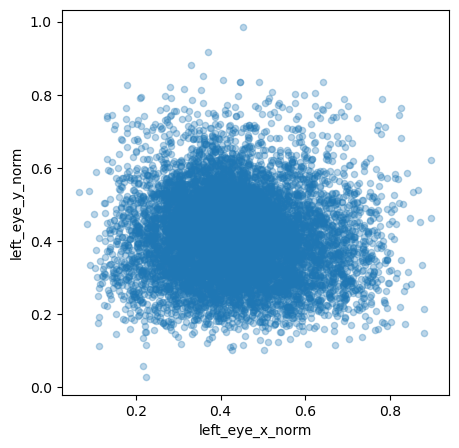

In [266]:
df.plot.scatter(
    x="left_eye_x_norm",
    y="left_eye_y_norm",
    alpha=0.3,
    figsize=(5,5)
)


In [267]:
df.groupby("label")["eye_dist"].mean()


label
0          NaN
1    78.813144
Name: eye_dist, dtype: float64

In [268]:
#Checking for symmetry 
#Eye center
# Eye center X (pixel space)
df["eye_center_x"] = (df["left_eye_x"] + df["right_eye_x"]) / 2

# Normalized eye center X
df["eye_center_x_norm"] = df["eye_center_x"] / df["width"]

df["eye_center_x"].describe()

count    9997.000000
mean      302.872812
std       145.496872
min        42.000000
25%       204.000000
50%       259.000000
75%       361.500000
max       927.000000
Name: eye_center_x, dtype: float64

In [269]:
#Checking for symmetry 
df["eye_center_y"] = (df["left_eye_y"] + df["right_eye_y"]) / 2

# Normalized eye center Y
df["eye_center_y_norm"] = df["eye_center_y"] / df["height"]
df["eye_center_y"].describe()



count    9997.000000
mean      213.862109
std       103.114710
min        21.500000
25%       143.500000
50%       182.500000
75%       259.500000
max       783.000000
Name: eye_center_y, dtype: float64

In [270]:
#Veritical eye allignment
df["eye_y_diff_norm"] = abs(df["right_eye_y_norm"] - df["left_eye_y_norm"])
df["eye_y_diff_norm"].describe()

count    9997.000000
mean        0.028670
std         0.042868
min         0.000000
25%         0.005208
50%         0.013333
75%         0.032746
max         0.440104
Name: eye_y_diff_norm, dtype: float64

In [271]:
# Adding Eye angle
import numpy as np

# Compute face tilt angle using eye landmarks
df["eye_angle"] = np.arctan2(
    df["right_eye_y"] - df["left_eye_y"],
    df["right_eye_x"] - df["left_eye_x"]
)
df["eye_angle"].describe

<bound method NDFrame.describe of 0        0.031240
1        0.498117
2        0.090660
3        0.158655
4       -0.015624
           ...   
24992         NaN
24993         NaN
24994         NaN
24995         NaN
24996         NaN
Name: eye_angle, Length: 24997, dtype: float64>

In [272]:
#position of mouth
df["mouth_eye_y_norm"] = df["mouth_y_norm"] - df["eye_center_y_norm"]
df["mouth_eye_y_norm"].describe

<bound method NDFrame.describe of 0        0.678000
1        0.702667
2        0.405333
3        0.522667
4        0.635135
           ...   
24992         NaN
24993         NaN
24994         NaN
24995         NaN
24996         NaN
Name: mouth_eye_y_norm, Length: 24997, dtype: float64>

### Landmark analysis: We performed exploratory analysis on normalized facial landmarks to validate annotation quality and geometric consistency. Landmark coordinates were normalized by image dimensions to ensure scale invariance. The spatial distribution of eye landmarks formed a compact cluster near the center of the image, indicating consistent framing and accurate labeling. Inter-ocular distance statistics showed stable facial geometry across samples, with no evidence of systematic left/right inversion. These results confirm the dataset is suitable for downstream landmark-based modeling.

In [273]:
# checking to see class imbalance
df["label"].value_counts().rename({0: "non_cat", 1: "cat"})



label
non_cat    15000
cat         9997
Name: count, dtype: int64

### The combined dataset contains 15000 non cat and 9997 cat images. This shows a moderate class imbalance. To address this imbalance during model training, on-the-fly data augmentation will be applied to the cat class, effectively increasing its representation without duplicating stored data or increasing storage costs.

In [274]:
df[["width", "height"]].describe()


,width,height
count,24997.000000,24997.000000
mean,261.091931,227.288835
std,318.204735,273.232874
min,32.000000,32.000000
25%,32.000000,32.000000
50%,32.000000,32.000000
75%,500.000000,375.000000
max,1024.000000,1024.000000


array([[<Axes: title={'center': 'width'}>,
        <Axes: title={'center': 'height'}>]], dtype=object)

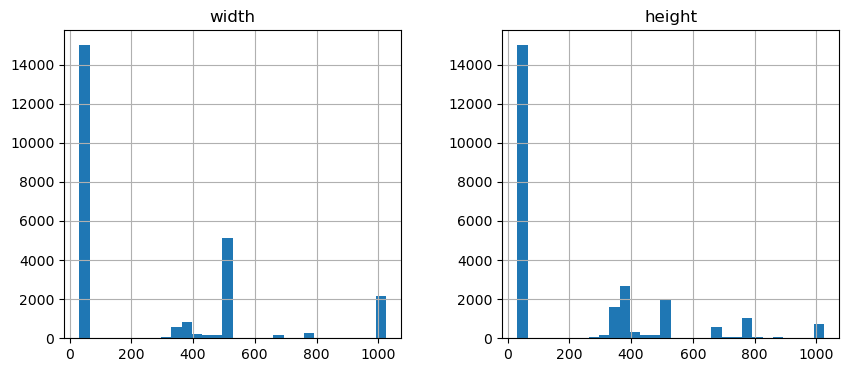

In [57]:
df[["width", "height"]].hist(bins=30, figsize=(10,4))


### From the above width and height histograms we can see that images vary significantly in resolution, ranging from small thumbnails to high-resolution images. A large concentration of images appears at lower resolutions, with several distinct clusters corresponding to common dataset sizes. This variability confirms that image resizing will be required during model training to ensure consistent input dimensions. 
### We will avoid permanently resizing and storing images prior to modeling. Instead, image resizing will be performed dynamically during the training pipeline. This approach preserves the raw image data in its original form while also keeping storage costs lower. Permanently resizing images would irreversibly discard information and reduce flexibility if different input resolutions are required for experimentation or future models. 
### Additionally, performing resizing at training time enables the use of random crops, padding, and scaling as part of data augmentation. This allows the model to observe varied spatial representations of the same image across training epochs, improving generalization and robustness without increasing storage costs or duplicating data in Amazon S3

In [261]:
df.head()

,s3_uri,label,file_size,width,height,left_eye_x,left_eye_y,right_eye_x,right_eye_y,mouth_x,...,eye_center_x,eye_center_y,eye_dist_norm,eye_y_diff_norm,eye_angle,mouth_y_norm,mouth_x_norm,eye_center_x_norm,eye_center_y_norm,mouth_eye_y_norm
0,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_000.jpg,1,469801,375,500,175.0,160.0,239.0,162.0,199.0,...,207.0,161.0,0.170667,0.004000,0.031240,0.398000,0.530667,0.552,0.322000,0.076000
1,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_005.jpg,1,469801,500,375,96.0,96.0,153.0,127.0,103.0,...,124.5,111.5,0.114000,0.082667,0.498117,0.389333,0.206000,0.249,0.297333,0.092000
2,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_008.jpg,1,469801,500,375,318.0,222.0,340.0,224.0,327.0,...,329.0,223.0,0.044000,0.005333,0.090660,0.634667,0.654000,0.658,0.594667,0.040000
3,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_011.jpg,1,310372,500,375,167.0,173.0,242.0,185.0,191.0,...,204.5,179.0,0.150000,0.032000,0.158655,0.658667,0.382000,0.409,0.477333,0.181333
4,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_012.jpg,1,310372,500,333,115.0,122.0,179.0,121.0,133.0,...,147.0,121.5,0.128000,0.003003,-0.015624,0.507508,0.266000,0.294,0.364865,0.142643


In [282]:
df[
    [
        "eye_center_x_norm",
        "eye_center_y_norm",
        "eye_dist_norm",
        "eye_y_diff_norm",
        "eye_angle",
        "mouth_x_norm",
        "mouth_y_norm",
        "mouth_eye_y_norm",
    ]
].describe()


,eye_center_x_norm,eye_center_y_norm,eye_dist_norm,eye_y_diff_norm,eye_angle,mouth_x_norm,mouth_y_norm,mouth_eye_y_norm
count,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,0.500645,0.413803,0.133363,0.028670,-0.001862,0.500986,0.530822,0.586197
std,0.125136,0.111404,0.068602,0.042868,0.354859,0.128197,0.140689,0.111404
min,0.091000,0.027995,0.000000,0.000000,-3.107707,0.076372,0.134115,0.022590
25%,0.425000,0.333333,0.082000,0.005208,-0.092756,0.420000,0.430000,0.513000
50%,0.499023,0.414000,0.121094,0.013333,0.000000,0.500000,0.528000,0.586000
75%,0.574000,0.487000,0.174000,0.032746,0.099669,0.580000,0.627494,0.666667
max,0.928000,0.977410,0.614000,0.440104,3.088072,0.956000,1.000000,0.972005


In [285]:

df["area"] = df["width"] * df["height"]
df["log_file_size"] = np.log1p(df["file_size"])


In [286]:
df["aspect_ratio"] = df["width"] / df["height"]
df["aspect_ratio"].describe()


count    24997.000000
mean         1.082926
std          0.214660
min          0.408000
25%          1.000000
50%          1.000000
75%          1.296203
max          3.938462
Name: aspect_ratio, dtype: float64

### The aspect ratio distribution has a median of 1.0, indicating that most images are approximately square. However, the presence of outliers with aspect ratios up to 3.9 suggests some wide or panoramic images. These findings further support the decision to perform resizing and normalization during training rather than permanently altering raw images.

In [291]:
# Create=ing df_final for Feature Store usage

df_final = df[
    [
        # Record identifier
        "s3_uri",
        # Label
        "label",
        # Basic image metadata
        "file_size",
        "width",
        "height",
        "aspect_ratio",
        "area",
        "log_file_size",
        # Eye geometry (normalized)
        "eye_center_x_norm",
        "eye_center_y_norm",
        "eye_dist_norm",
        "eye_y_diff_norm",
        "eye_angle",
        # Mouth geometry (normalized)
        "mouth_x_norm",
        "mouth_y_norm",
        "mouth_eye_y_norm",
    ]
].copy()

# Rename s3_uri → image_id for Feature Store consistency
df_final = df_final.rename(columns={"s3_uri": "image_id"})


In [296]:
# 1) Write locally as parquet, then upload to S3
#    (Keeps the workflow identical to image_combined)

# --- imports ---
from pathlib import Path
import boto3

# --- write parquet locally ---
out_dir = Path("data/processed/combined_features")
out_dir.mkdir(parents=True, exist_ok=True)

local_parquet = out_dir / "image_landmarks_features.parquet"
df_final.to_parquet(local_parquet, index=False)

# --- upload to S3 ---
bucket = "sagemaker-us-east-1-549206572067"
s3_prefix = "cat-landmarks-project/processed/combined/image_landmarks_features/" 

s3 = boto3.client("s3", region_name="us-east-1")
s3_key = f"{s3_prefix}{local_parquet.name}"

s3.upload_file(str(local_parquet), bucket, s3_key)

print("Uploaded to:", f"s3://{bucket}/{s3_key}")


Uploaded to: s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/processed/combined/image_landmarks_features/image_landmarks_features.parquet


In [293]:
df_final.head()

,image_id,label,file_size,width,height,aspect_ratio,area,log_file_size,eye_center_x_norm,eye_center_y_norm,eye_dist_norm,eye_y_diff_norm,eye_angle,mouth_x_norm,mouth_y_norm,mouth_eye_y_norm
0,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_000.jpg,1,469801,375,500,0.750000,187500,13.060067,0.552,0.322000,0.170667,0.004000,0.031240,0.530667,0.398000,0.678000
1,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_005.jpg,1,469801,500,375,1.333333,187500,13.060067,0.249,0.297333,0.114000,0.082667,0.498117,0.206000,0.389333,0.702667
2,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_008.jpg,1,469801,500,375,1.333333,187500,13.060067,0.658,0.594667,0.044000,0.005333,0.090660,0.654000,0.634667,0.405333
3,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_011.jpg,1,310372,500,375,1.333333,187500,12.645530,0.409,0.477333,0.150000,0.032000,0.158655,0.382000,0.658667,0.522667
4,s3://sagemaker-us-east-1-549206572067/cat-landmarks-project/raw/cats/images/CAT_00/00000001_012.jpg,1,310372,500,333,1.501502,166500,12.645530,0.294,0.364865,0.128000,0.003003,-0.015624,0.266000,0.507508,0.635135


In [298]:
# Create an Athena table pointing at the folder that contains the parquet
# (Use a NEW table name to avoid breaking existing ones)

table_name_features = "image_landmarks_features"
s3_features_location = f"s3://{bucket}/{s3_prefix}"

# NOTE: keep the column list aligned with df columns (names + types)
# Use DOUBLE for float columns; BIGINT for ints; STRING for s3_uri

statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_features} (
    image_id STRING,
    label BIGINT,
    file_size BIGINT,
    width BIGINT,
    height BIGINT,
    aspect_ratio DOUBLE,
    area BIGINT,
    log_file_size DOUBLE,

    eye_center_x_norm DOUBLE,
    eye_center_y_norm DOUBLE,
    eye_dist_norm DOUBLE,
    eye_y_diff_norm DOUBLE,
    eye_angle DOUBLE,
    
    mouth_x_norm DOUBLE,
    mouth_y_norm DOUBLE,
    mouth_eye_y_norm DOUBLE

    
)
STORED AS PARQUET
LOCATION '{s3_features_location}'
"""

cursor = conn.cursor()
cursor.execute(statement)
print("Created table:", f"{database_name}.{table_name_features}")


Created table: cat_image_analysis.image_landmarks_features
